<a href="https://colab.research.google.com/github/moajjem04/Pytorch_Practice/blob/main/CNN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a colab code following the tutorial by [Jason Brownlee](https://machinelearningmastery.com/about/) named [**PyTorch Tutorial: How to Develop Deep Learning Models with Python**](https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/). I will be specifically following the steps for CNN on MNIST data.

As explained in the tutorial, the process of deep learning consists of a cycle of:

1. Prepare the Data.
2. Define the Model.
3. Train the Model.
4. Evaluate the Model.
5. Make Predictions.

# 1. Prepare the Data

## Import Modules

In [1]:
from torch.utils.data        import DataLoader # for easier handling of data
from torchvision.datasets    import MNIST      # the dataset
from torchvision.transforms  import Compose    # for preprocessing
from torchvision.transforms  import ToTensor   # converts to tensor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot    as plt            # for visualisation
%matplotlib inline
import numpy                as np

## Downloading MNIST Data

In [2]:
%%capture
# define location to save or load the dataset
path = '~/.torch/datasets/mnist'
# define the transforms to apply to the data
trans = Compose([ToTensor()])
# download and define the datasets
main_data = MNIST(path, train=True, download=True, transform=trans)
test = MNIST(path, train=False, download=True, transform=trans)
# splitting into train and val set
train, val = train_test_split(main_data,train_size = 0.8)
# define how to enumerate the datasets
train_dl = DataLoader(train, batch_size=100, shuffle=True)
val_dl = DataLoader(val, batch_size=100, shuffle=True)
test_dl = DataLoader(test, batch_size=100, shuffle=True)

In [3]:
print('Train Set length:',len(train_dl.dataset))
print('Val Set length:',len(val_dl.dataset))
print('Test Set length:',len(test_dl.dataset))

Train Set length: 48000
Val Set length: 12000
Test Set length: 10000


## Display a batch of image

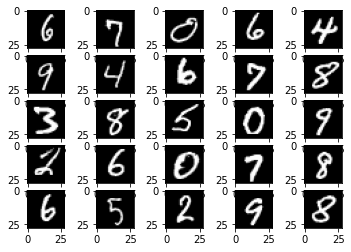

In [4]:
# get one batch of images
i, (inputs, targets) = next(enumerate(train_dl))
# plot some images
for i in range(25):
	# define subplot
	plt.subplot(5, 5, i+1)
	# plot raw pixel data
	plt.imshow(inputs[i][0], cmap='gray')

# show the figure
plt.show()

# 2. Define the Model

In [5]:
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from sklearn.metrics import accuracy_score
import torch
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import Flatten
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

In [6]:
# model definition
class CNN(Module):
    # define model elements
    def __init__(self, n_channels):
        super(CNN, self).__init__()
        # input to first hidden layer
        self.hidden1 = Conv2d(n_channels, 32, (3,3))
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # first pooling layer
        self.pool1 = MaxPool2d((2,2), stride=(2,2))
        # second hidden layer
        self.hidden2 = Conv2d(32, 32, (3,3))
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # second pooling layer
        self.pool2 = MaxPool2d((2,2), stride=(2,2))

        x = torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)

        # Flatten
        self.flat = Flatten()
        # fully connected layer
        self.hidden3 = Linear(self._to_linear, 100)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # output layer
        self.hidden4 = Linear(100, 10)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = Softmax(dim=1)

    # forward propagate for just conv layer
    def convs(self, X):
        # max pooling over 2x2
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.pool1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.pool2(X)
        #print(x[0].shape)

        if self._to_linear is None:
          self._to_linear = X[0].shape[0]*X[0].shape[1]*X[0].shape[2]
        return X
 
    # forward propagate input
    def forward(self, X):
        X = self.convs(X)
        # flatten
        X = self.flat(X)
        # third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        # output layer
        X = self.hidden4(X)
        X = self.act4(X)
        return X

In [52]:
# define the network
model = CNN(1)
model.cuda()
print(model)

CNN(
  (hidden1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (hidden2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (hidden3): Linear(in_features=800, out_features=100, bias=True)
  (act3): ReLU()
  (hidden4): Linear(in_features=100, out_features=10, bias=True)
  (act4): Softmax(dim=1)
)


In [8]:
from torchsummary import summary
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 32, 11, 11]           9,248
              ReLU-5           [-1, 32, 11, 11]               0
         MaxPool2d-6             [-1, 32, 5, 5]               0
           Flatten-7                  [-1, 800]               0
            Linear-8                  [-1, 100]          80,100
              ReLU-9                  [-1, 100]               0
           Linear-10                   [-1, 10]           1,010
          Softmax-11                   [-1, 10]               0
Total params: 90,678
Trainable params: 90,678
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [9]:
%%capture
!pip install torchviz

In [10]:
%%capture
from torchviz import make_dot
x = torch.zeros(1, 1, 28, 28, dtype=torch.float, requires_grad=False)
x = x.cuda()
out = model(x)
make_dot(out)  # plot graph of variable, not of a nn.Module

# 3. Train the Model

In [11]:
from tqdm import tqdm

In [53]:
# train the model
def train_model(train_dl, model,epochs):
  # enumerate epochs
  for epoch in range(epochs):
    temp_train_loss = 0
    temp_val_loss   = 0
      # enumerate mini batches
    for i ,(inputs,targets)in enumerate(tqdm(train_dl)):
      # In CUDA
      if torch.cuda.is_available():
        inputs = inputs.cuda()
        targets = targets.cuda()
      # clear the gradients
      optimizer.zero_grad()
      # compute the model output
      yhat = model(inputs)
      # calculate loss
      loss = criterion(yhat, targets)
      temp_train_loss += loss.item()
      # credit assignment
      loss.backward()
      # update model weights
      optimizer.step()

    with torch.no_grad():
      for i ,(inputs,targets)in enumerate(val_dl):
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          targets = targets.cuda()
        yhat = model(inputs)
        loss_val = criterion(yhat,targets)
        temp_val_loss += loss_val.item()

    train_losses.append(temp_train_loss/len(train_dl.dataset))
    val_losses.append(temp_val_loss/len(val_dl.dataset))
    print('\tEpoch : ',epoch+1)


In [62]:
# define the network
model = CNN(1)
model.cuda()
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
  criterion = criterion.cuda()
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
train_losses = []
val_losses = []

In [65]:
# # train the model
train_model(train_dl, model,10)

  8%|▊         | 37/480 [00:00<00:01, 367.90it/s]

	Epoch :  1


  8%|▊         | 36/480 [00:00<00:01, 357.75it/s]

	Epoch :  2


  8%|▊         | 37/480 [00:00<00:01, 368.04it/s]

	Epoch :  3


  8%|▊         | 37/480 [00:00<00:01, 362.50it/s]

	Epoch :  4


  6%|▌         | 27/480 [00:00<00:01, 265.93it/s]

	Epoch :  5


  8%|▊         | 36/480 [00:00<00:01, 358.19it/s]

	Epoch :  6


  6%|▋         | 30/480 [00:00<00:01, 291.80it/s]

	Epoch :  7


  6%|▌         | 29/480 [00:00<00:01, 281.89it/s]

	Epoch :  8


  6%|▋         | 31/480 [00:00<00:01, 304.14it/s]

	Epoch :  9


100%|██████████| 480/480 [00:01<00:00, 338.64it/s]


	Epoch :  10


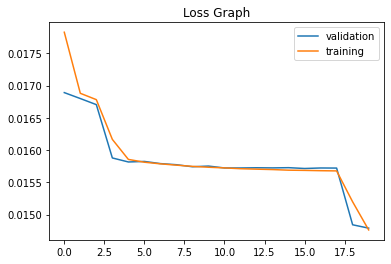

In [66]:
plt.plot(val_losses,label = 'validation')
plt.plot(train_losses,label = 'training')
plt.legend(loc="upper right")
plt.title('Loss Graph')
plt.show()

# 4. Evaluate the Model

In [46]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        if torch.cuda.is_available():
          inputs = inputs.cuda()
          targets = targets.cuda()
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.cpu().detach().numpy()
        actual = targets.cpu().numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [67]:
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)

Accuracy: 0.986


# Visualilize Each Conv Layer

In [87]:
a = model.state_dict()
a.keys()

odict_keys(['hidden1.weight', 'hidden1.bias', 'hidden2.weight', 'hidden2.bias', 'hidden3.weight', 'hidden3.bias', 'hidden4.weight', 'hidden4.bias'])

In [118]:
import torchvision 

kernels = model.hidden2.weight.detach().clone()
#check size for sanity check
print(kernels.size())
kernels = kernels.view(-1,1,3,3)
print(kernels.size())
# can plot them
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
filter_img = torchvision.utils.make_grid(kernels, nrow = 8)
filter_img = filter_img.cpu()
filter_img.shape
# change ordering since matplotlib requires images to 
# be (H, W, C)
# plt.figure(figsize = (20,20))
# plt.imshow(filter_img.permute(1, 2, 0))
print(filter_img.permute(1, 2, 0).size())

torch.Size([32, 32, 3, 3])
torch.Size([1024, 1, 3, 3])
torch.Size([642, 42, 3])


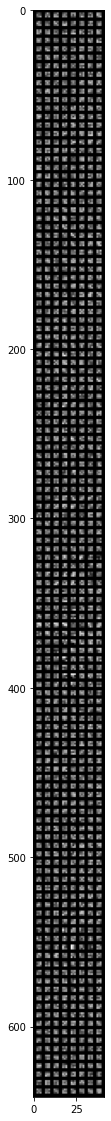

In [119]:
plt.figure(figsize = (20,20))
plt.imshow(filter_img.permute(1, 2, 0))

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))


if __name__ == "__main__":
    layer = 1
    filter = model.features[layer].weight.data.clone()
    visTensor(filter, ch=0, allkernels=False)

    plt.axis('off')
    plt.ioff()
    plt.show()

ModuleAttributeError: ignored

# 5. Make Predictions